# Project Template: Phase 1

Below are some concrete steps that you can take while doing your analysis. This guide isn't "one size fit all" so you will probably not do everything listed. But it still serves as a good "pipeline" for how to do data analysis.

If you do engage in a step, you should clearly mention it in the notebook.

---


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import json
import glob
import os
import warnings

warnings.filterwarnings('ignore')


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from datetime import datetime
from dateutil import parser

## Loading Data

In the cells below, make sure to do the following:

1. Load your dataset. If your dataset contains multiple files (e.g. AirBnB), make sure to merge them.
2. Decide what attribute you want to predict (you can change your mind later during EDA if needed).

### Types of Attributes

Below are some examples of types of attributes you may encounter. For some types of data, ML algorithms cannot use them directly, so we have to encode them somehow. We have summarized ways to deal with these non-traditional data types. There are more examples in Follow content for this week.

Make a note of which types of data your dataset has.

Traditional data types (individual numbers/values): no transformation needed

  * Nominal
    * Binary
  * Ordinal
  * Interval
  * Ratio
  * Continuous
  * Discrete

Non-traditional data types:
 
* **Text**
    * Encode with: [Bag of Words](https://scikit-learn.org/stable/modules/feature_extraction.html#the-bag-of-words-representation), [TF-IDF](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting), Embeddings
* **Sets** (e.g. tags {"Blog", "Video", "Finance Article"})
    * We should not treat these like  bag of words, since tags can be multi word
    * We can use [one hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).
* **Time series data**: A series of numbers, e.g. predict the stock price next year from the last N years of prices.
    * Naive approaches: We can use each of the following as a separate feature:
        * Last value: Use the last value in the series.
        * Average, Median: Use the average or median of the values.
        * Max/min: Use the max and min of the values.
    * A more effective approach is to use a ML model that can take time-series data in as an input, such as an [Long Short-Term Memory](https://en.wikipedia.org/wiki/Long_short-term_memory) model, but these are out of scope for this course.
* **Numeric Data** that isn't directly interpretable (e.g. geospatial data)
    * This varies from situation to situation. Sometimes your data is numeric but isn't directly predictive of your class label (e.g. latitude and longitude; movie title). However, you may be able to combine this with other datasets to construct more meaningful features (e.g. State, Movie Genre).

In [2]:
# Load your datasets
train = pd.read_csv("./ECONet/train.csv")
test = pd.read_csv("./ECONet/test.csv")

The attribute we will predict is: **Target**

## Exploratory Data Analysis (EDA)

Using some of the techniques in the "Follow" document, explore your dataset. Then answer the following questions (you don't have to solve the problems yet - just be aware of them):

In [3]:
# Print the training set
train

,Station,Ob,value,measure,target,R_flag,I_flag,Z_flag,B_flag
0,AURO,1/2/2021 0:30,19.200,temp_wxt,False,2,-1,0,1
1,AURO,1/2/2021 4:30,19.800,temp_wxt,False,2,-1,0,1
2,AURO,1/2/2021 5:30,19.500,temp_wxt,False,2,-1,0,1
3,AURO,1/2/2021 7:30,18.500,temp_wxt,False,2,-1,0,1
4,AURO,2/16/2021 2:30,17.700,temp_wxt,False,2,-1,0,1
...,...,...,...,...,...,...,...,...,...
6593269,WINE,4/3/2021 6:26,-5.289,blackglobetemp,False,4,-1,-1,-1
6593270,WINE,4/3/2021 6:27,-5.189,blackglobetemp,False,4,-1,-1,-1
6593271,WINE,4/3/2021 6:28,-5.123,blackglobetemp,False,4,-1,-1,-1
6593272,WINE,4/3/2021 6:29,-5.090,blackglobetemp,False,4,-1,-1,-1


In [4]:
# Describe the training set
train.describe()

,value,R_flag,I_flag,Z_flag,B_flag
count,6.593274e+06,6.593274e+06,6.593274e+06,6.593274e+06,6.593274e+06
mean,9.025752e+01,5.219563e-01,-5.984280e-01,-7.830579e-01,5.414459e-01
std,2.825799e+02,1.154504e+00,1.003581e+00,6.345782e-01,1.062219e+00
min,-1.262000e+02,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,2.150000e-01,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
50%,4.670000e-01,0.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00
75%,1.117000e+01,0.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00
max,3.421000e+03,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00


[Text(0, 0, 'AURO'),
 Text(1, 0, 'BAHA'),
 Text(2, 0, 'BALD'),
 Text(3, 0, 'BEAR'),
 Text(4, 0, 'BUCK'),
 Text(5, 0, 'BURN'),
 Text(6, 0, 'CAST'),
 Text(7, 0, 'CHAP'),
 Text(8, 0, 'CLA2'),
 Text(9, 0, 'CLAY'),
 Text(10, 0, 'CLIN'),
 Text(11, 0, 'DURH'),
 Text(12, 0, 'FLET'),
 Text(13, 0, 'FRYI'),
 Text(14, 0, 'GOLD'),
 Text(15, 0, 'HAML'),
 Text(16, 0, 'JACK'),
 Text(17, 0, 'JEFF'),
 Text(18, 0, 'KINS'),
 Text(19, 0, 'LAKE'),
 Text(20, 0, 'LAUR'),
 Text(21, 0, 'LEWS'),
 Text(22, 0, 'LILE'),
 Text(23, 0, 'MITC'),
 Text(24, 0, 'NCAT'),
 Text(25, 0, 'NEWL'),
 Text(26, 0, 'OXFO'),
 Text(27, 0, 'PLYM'),
 Text(28, 0, 'REED'),
 Text(29, 0, 'REID'),
 Text(30, 0, 'ROCK'),
 Text(31, 0, 'SALI'),
 Text(32, 0, 'SASS'),
 Text(33, 0, 'SILR'),
 Text(34, 0, 'SPIN'),
 Text(35, 0, 'SPRU'),
 Text(36, 0, 'TAYL'),
 Text(37, 0, 'UNCA'),
 Text(38, 0, 'WAYN'),
 Text(39, 0, 'WHIT'),
 Text(40, 0, 'WILD'),
 Text(41, 0, 'WILL'),
 Text(42, 0, 'WINE')]

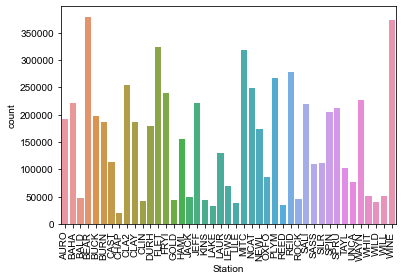

In [5]:
# Get counts of "station" values in the training set
countplot = sns.countplot(x=train["Station"])
sns.set(rc={'figure.figsize':(20,20)})
countplot.set_xticklabels(countplot.get_xticklabels(),rotation=90)

In [6]:
# Get counts of "target" values in the training set
# Target=True only accounts for about ~3.5% of data
train["target"].value_counts()

False    6358102
True      235172
Name: target, dtype: int64

[Text(0, 0, 'temp_wxt'),
 Text(1, 0, 'rh_wxt'),
 Text(2, 0, 'ws10'),
 Text(3, 0, 'precip'),
 Text(4, 0, 'par'),
 Text(5, 0, 'sr'),
 Text(6, 0, 'st'),
 Text(7, 0, 'sm'),
 Text(8, 0, 'temp10'),
 Text(9, 0, 'ws02'),
 Text(10, 0, 'ws06'),
 Text(11, 0, 'blackglobetemp'),
 Text(12, 0, 'leafwetness'),
 Text(13, 0, 'rh_hmp'),
 Text(14, 0, 'pres'),
 Text(15, 0, 'impact')]

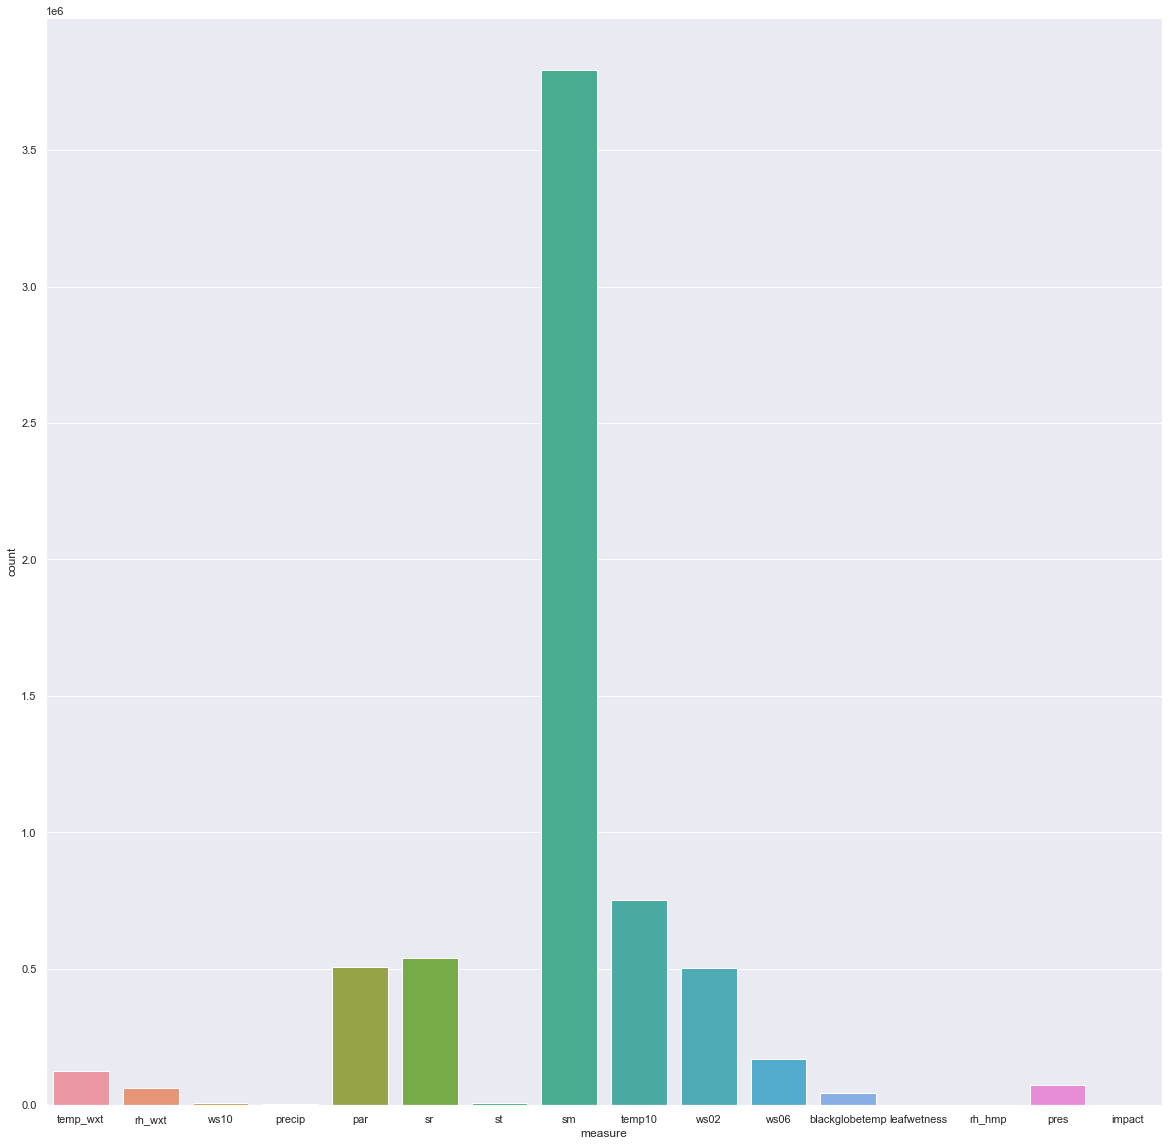

In [7]:
# Get counts of "measure" values in the training set
countplot = sns.countplot(x=train["measure"])
sns.set(rc={'figure.figsize':(40,20)})
countplot.set_xticklabels(countplot.get_xticklabels(),rotation=0)

1. What attribute are you predicting and what type of supervised learning is this?
    * Binary Classification: Just 2 class labels
    * Multi-class classification: More than 2 class labels
    * Regression: A continuous variable
    * Ordinal classification: Predicting an ordinal value, e.g. a rating on a 5-star scale 
        * This is tricky! Do you want to change this into regression or binarize your variable to make this binary classification?

2. Do you need to perform feature selection?
    * E.g. do you have hihgly correlated features?

3. Do you have any non-traditional attributes (see the list above)? If so how will you encode them? (You don't have to do it yet.)

4. If you are doing classification, are your class labels balanced (similar numbers of instances from each class)?

5. If you are doing regression, how is your dependent variable distributed (e.g. normally, skewed)?
    
6. Do any of your features need transformation (e.g. because they have a skewed distribution)?


Answer the questions below:

1. We are predicting the value of the "Target" attribute. This is a binary classification task, as Target is a boolean value.
2. No. Feature selection is not necessary for this dataset.
3. Yes. The station and measure features will have to be encoded using label encoding.
4. The class labels are severely unbalanced. The positive class label (Target=True) accounts for only ~3.5% of instances in the dataset.
5. N/A. We are not performing regression.
6. Yes. We will be using SMOTE to make the class distribution less skewed.

## Preprocessing

Do the following steps on your data (and any others you think are needed). See the "Follow" examples, as well as the original Week 2 materials for more on how to do each step.

1. **Feature Cleaning**: Remove meaningless features (e.g. IDs), or unfair features that make the problem too easy (e.g. percent grade should be removed if predicing final letter grade).
2. **Feature Discretization**: Discretize any attributes that should be discretized.
3. **Feature Transformation** Encode non-standard features into usable formats (standardize dates, vectorize words). Tranform any features (e.g. using a log-transform) as needed.
4. **Feature Selection**: Remove redundant, noisy features or unhelpful features.
5. **Aggregation**: If your data has multiple rows per class label, transform it so that there is only one row per class label.

Now revisit EDA as needed to see what your transformed dataset looks like.

If you don't need to do a given step, just skip it an exaplin why.

### 1) Feature cleaning

In [8]:
# No feature cleaning necessary. All features are meaningful.

### 2) Feature discretization

In [9]:
# We will not be performing feature discretization as SMOTE depends on continuous features to work.

### 3) Feature transformation


In [10]:
# We will transform the "Ob" attribute's values from datetime to UNIX timestamps 
# so they can be interpreted by our SMOTE algorithm

# Function to convert the values to timestamps
def stringToTimestamp(dateTimeString):
    dateTime = parser.parse(dateTimeString)
    timeStamp = datetime.timestamp(dateTime)
    return timeStamp

# Change each ob value to a timestamp
train['Ob'] = train['Ob'].map(stringToTimestamp)
test['Ob'] = test['Ob'].map(stringToTimestamp)

### 4) Feature selection

In [11]:
# We will not be performing feature selection as there are so few features we do not feel that it is necessary.

### 5) Aggregation

In [12]:
# No aggregation is necessary. Each class label only has one row

### Revisiting EDA

In [13]:
# Each train/test 'Ob' value should now be a unix timestamp

In [14]:
train

,Station,Ob,value,measure,target,R_flag,I_flag,Z_flag,B_flag
0,AURO,1.609565e+09,19.200,temp_wxt,False,2,-1,0,1
1,AURO,1.609580e+09,19.800,temp_wxt,False,2,-1,0,1
2,AURO,1.609583e+09,19.500,temp_wxt,False,2,-1,0,1
3,AURO,1.609591e+09,18.500,temp_wxt,False,2,-1,0,1
4,AURO,1.613461e+09,17.700,temp_wxt,False,2,-1,0,1
...,...,...,...,...,...,...,...,...,...
6593269,WINE,1.617446e+09,-5.289,blackglobetemp,False,4,-1,-1,-1
6593270,WINE,1.617446e+09,-5.189,blackglobetemp,False,4,-1,-1,-1
6593271,WINE,1.617446e+09,-5.123,blackglobetemp,False,4,-1,-1,-1
6593272,WINE,1.617446e+09,-5.090,blackglobetemp,False,4,-1,-1,-1


In [15]:
test

,Station,Ob,value,measure,R_flag,I_flag,Z_flag,B_flag
0,AURO,1.616683e+09,24.500,temp_wxt,2,-1,2,0
1,AURO,1.626024e+09,31.500,temp_wxt,2,-1,0,1
2,AURO,1.626024e+09,31.500,temp_wxt,2,-1,0,1
3,AURO,1.626024e+09,31.500,temp_wxt,2,-1,0,1
4,AURO,1.626024e+09,31.600,temp_wxt,2,-1,0,1
...,...,...,...,...,...,...,...,...
1856101,WINE,1.619064e+09,-7.890,blackglobetemp,4,-1,-1,-1
1856102,WINE,1.619064e+09,-7.890,blackglobetemp,4,-1,-1,-1
1856103,WINE,1.619064e+09,-7.927,blackglobetemp,4,-1,-1,-1
1856104,WINE,1.619064e+09,-7.927,blackglobetemp,4,-1,-1,-1


## Export Dataset to Part 2

In [16]:
# Export the new preprocessed dataframe to csv for use in part 2
train.to_csv('transformed_train.csv', index=False)
test.to_csv('transformed_test.csv', index=False)